In [1]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple, Optional

class SurvivalDataPreprocessor:
    def __init__(self, categorical_features: List[str]):
        """
        Initialize the preprocessor with a list of categorical features.
        
        Args:
            categorical_features: List of column names for categorical variables
        """
        self.categorical_features = categorical_features
        self.label_encoders = {}
        
    def calculate_survival_probabilities(self, 
                                      df: pd.DataFrame, 
                                      time_col: str, 
                                      event_col: str) -> np.ndarray:
        """
        Calculate survival probabilities using Kaplan-Meier estimator.
        
        Args:
            df: Input DataFrame
            time_col: Name of the column containing time data
            event_col: Name of the column containing event indicators
            
        Returns:
            Array of survival probabilities
        """
        if not all(col in df.columns for col in [time_col, event_col]):
            raise ValueError(f"Missing required columns: {time_col} and/or {event_col}")
            
        df = df.reset_index(drop=True)
        kmf = KaplanMeierFitter()
        kmf.fit(df[time_col], df[event_col])
        return kmf.predict(df[time_col]).values
    
    def preprocess_data(self,
                       train_data: pd.DataFrame,
                       test_data: pd.DataFrame,
                       time_col: str = 'efs_time',
                       event_col: str = 'efs',
                       id_col: str = 'ID') -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Preprocess training and test data for survival analysis.
        
        Args:
            train_data: Training DataFrame
            test_data: Test DataFrame
            time_col: Name of the time column
            event_col: Name of the event column
            id_col: Name of the ID column
            
        Returns:
            Tuple of (X_train, y_train, X_test, test_data_original)
        """
        # Make copies to avoid modifying original data
        train_df = train_data.copy()
        test_df = test_data.copy()
        
        # Calculate survival probabilities for training data
        train_df['target'] = self.calculate_survival_probabilities(train_df, time_col, event_col)
        
        # Combine datasets for consistent preprocessing
        train_df['Dataset'] = 'train'
        test_df['Dataset'] = 'test'
        combined_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
        
        # Handle missing values in categorical columns
        for column in self.categorical_features:
            combined_df[column] = combined_df[column].fillna('unknown')
            
        # Encode categorical variables
        for category in self.categorical_features:
            if category in combined_df.columns:
                encoder = LabelEncoder()
                combined_df[category] = encoder.fit_transform(combined_df[category])
                combined_df[category] = combined_df[category].astype('category')
                self.label_encoders[category] = encoder
        
        # Split back into train and test
        train_processed = combined_df[combined_df['Dataset'] == 'train'].drop(columns=['Dataset', id_col])
        test_processed = combined_df[combined_df['Dataset'] == 'test'].drop(
            columns=['Dataset', event_col, time_col, 'target'] if all(col in combined_df.columns for col in [event_col, time_col, 'target']) else ['Dataset']
        )
        
        # Prepare final training features and target
        X_train = train_processed.drop(columns=[event_col, time_col, 'target'])
        y_train = train_processed[['target']]
        
        return X_train, y_train, test_processed, test_data
    
    def get_feature_names(self) -> List[str]:
        """Return the list of feature names after preprocessing."""
        return list(self.label_encoders.keys())

# Example usage:
# categorical_features = ['dri_score', 'psych_disturb', 'cyto_score', ...]
# preprocessor = SurvivalDataPreprocessor(categorical_features)
# X_train, y_train, X_test, test_data_original = preprocessor.preprocess_data(train_data, test_data)

In [2]:
DATA_DIR = 'equity-post-HCT-survival-predictions-1'
categories = ['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status',
              'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe',
              'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab',
              'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity',
              'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe',
              'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match',
              'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related',
              'melphalan_dose', 'cardiac', 'pulm_moderate']

In [3]:
#train_data = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
#test_data  = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

train_data = pd.read_csv(DATA_DIR +'/train.csv')
test_data  = pd.read_csv(DATA_DIR +'/test.csv')

In [14]:
# Initialize with your categorical features
preprocessor = SurvivalDataPreprocessor(categories)

# Preprocess the data
X_train, y_train, X_test, test_data_original = preprocessor.preprocess_data(
    train_data,
    test_data
)

In [5]:
from lifelines.utils import concordance_index
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def analyze_racial_survival_patterns(df):
    """
    Analyze survival patterns across racial groups
    """
    # Get unique racial groups
    racial_groups = df['race_group'].unique()

    # Calculate overall statistics by racial group
    racial_stats = pd.DataFrame()
    kmf = KaplanMeierFitter()

    # Plot survival curves by race
    plt.figure(figsize=(12, 8))

    for race in racial_groups:
        mask = df['race_group'] == race
        race_data = df[mask]

        # Fit KM curve for this racial group
        kmf.fit(race_data['efs_time'],
                race_data['efs'],
                label=f'Race: {race}')
        kmf.plot()

        # Calculate statistics
        stats = {
            'n_patients': len(race_data),
            'event_rate': race_data['efs'].mean(),
            'median_survival': race_data['efs_time'].median(),
            'mean_survival': race_data['efs_time'].mean()
        }
        racial_stats = pd.concat([racial_stats, pd.DataFrame([stats], index=[race])])

    plt.title('Survival Curves by Racial Group')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.grid(True)

    return racial_stats

def create_racial_interaction_features(df):
    """
    Create interaction features between race and key clinical predictors
    """
    # Key clinical features to interact with race
    clinical_features = [
        'age_at_hct',
        'comorbidity_score',
        'karnofsky_score',
        'dri_score',
        'donor_age'
    ]

    # Create one-hot encoded race features
    race_dummies = pd.get_dummies(df['race_group'], prefix='race')

    # Initialize DataFrame for interaction features
    interactions = pd.DataFrame()

    # Create interactions
    for race_col in race_dummies.columns:
        for clinical_feature in clinical_features:
            # Create interaction term
            interaction_name = f'{race_col}_{clinical_feature}'
            interactions[interaction_name] = df[clinical_feature] * race_dummies[race_col]

    return interactions

def calculate_racial_c_index(model, X, y, race_groups):
    """
    Calculate C-index for each racial group
    """
    c_indices = {}

    for race in race_groups:
        mask = X['race_group'] == race
        if mask.any():
            race_pred = model.predict_proba(X[mask])[:, 1]
            race_true = y[mask]
            c_index = concordance_index(race_true, race_pred)
            c_indices[race] = c_index

    return pd.Series(c_indices)

def create_demographic_features(df):
    """
    Create features that capture demographic-specific patterns
    """
    demographic_features = pd.DataFrame()

    # Age-related features
    demographic_features['age_group'] = pd.qcut(df['age_at_hct'], q=5, labels=['VeryYoung', 'Young', 'Middle', 'Old', 'VeryOld'])

    # Interaction between age and comorbidities
    demographic_features['age_comorbidity'] = df['age_at_hct'] * df['comorbidity_score']

    # Race-specific disease risk
    demographic_features['race_disease_risk'] = df['race_group'].astype(str) + '_' + df['dri_score'].astype(str)

    # Donor-recipient demographic matching
    demographic_features['donor_recipient_age_diff'] = abs(df['donor_age'] - df['age_at_hct'])

    return demographic_features

def print_racial_analysis_summary(racial_stats):
    """
    Print summary of racial survival analysis
    """
    print("\nSurvival Analysis by Racial Group:")
    print("-" * 50)
    print("\nPatient Distribution:")
    print(racial_stats['n_patients'])

    print("\nEvent Rates:")
    print(racial_stats['event_rate'])

    print("\nMedian Survival Times:")
    print(racial_stats['median_survival'])

    # Calculate disparities
    print("\nDisparities Analysis:")
    max_survival = racial_stats['median_survival'].max()
    min_survival = racial_stats['median_survival'].min()
    disparity_ratio = max_survival / min_survival
    print(f"Survival Disparity Ratio (max/min): {disparity_ratio:.2f}")


Survival Analysis by Racial Group:
--------------------------------------------------

Patient Distribution:
More than one race                           4845
Asian                                        4832
White                                        4831
American Indian or Alaska Native             4790
Native Hawaiian or other Pacific Islander    4707
Black or African-American                    4795
Name: n_patients, dtype: int64

Event Rates:
More than one race                           0.465841
Asian                                        0.551531
White                                        0.625543
American Indian or Alaska Native             0.510438
Native Hawaiian or other Pacific Islander    0.523476
Black or African-American                    0.558707
Name: event_rate, dtype: float64

Median Survival Times:
More than one race                           16.0660
Asian                                         8.9745
White                                         7.9840
Ameri

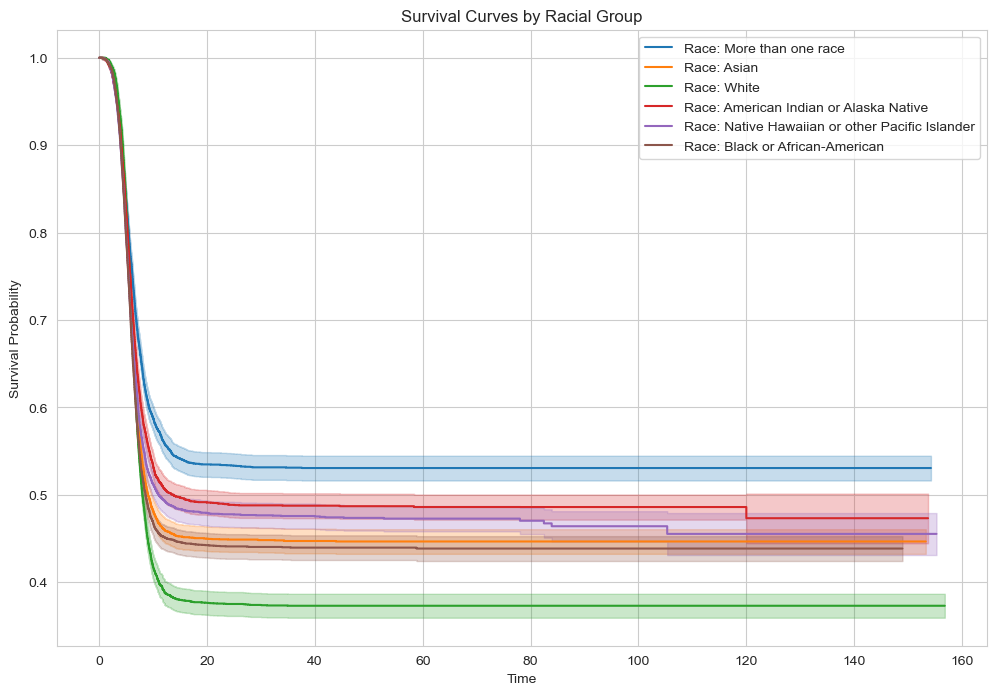

In [8]:
# 1. Analyze racial survival patterns
racial_stats = analyze_racial_survival_patterns(train_data)
print_racial_analysis_summary(racial_stats)

# 2. Create interaction features
interaction_features = create_racial_interaction_features(train_data)
demographic_features = create_demographic_features(train_data)

X = train_data.drop(columns=['efs', 'efs_time'])


# 3. Combine features for modeling
X_enhanced = pd.concat([X, interaction_features, demographic_features], axis=1)

In [29]:
X_enhanced.describe()

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,race_Native Hawaiian or other Pacific Islander_age_at_hct,race_Native Hawaiian or other Pacific Islander_comorbidity_score,race_Native Hawaiian or other Pacific Islander_karnofsky_score,race_Native Hawaiian or other Pacific Islander_donor_age,race_White_age_at_hct,race_White_comorbidity_score,race_White_karnofsky_score,race_White_donor_age,age_comorbidity,donor_recipient_age_diff
count,28800.000000,24180.000000,22971.000000,25530.000000,23516.000000,21637.000000,23601.000000,24603.000000,26000.000000,26157.000000,...,28800.000000,28323.000000,27930.000000,26992.000000,28800.000000,28323.000000,27930.000000,26992.000000,28323.000000,26992.000000
mean,14399.500000,1.764516,6.876801,5.143322,5.109202,8.617230,1.736876,5.160346,1.757808,1.715296,...,6.426872,0.303287,13.614751,7.144782,7.138030,0.294849,14.103473,6.848299,75.707990,19.376413
std,8313.988213,0.431941,1.564313,1.207757,1.214162,1.905125,0.447687,1.203240,0.435453,0.451282,...,16.844513,1.087818,31.214370,17.203464,17.887846,1.070575,31.490252,16.303261,109.842775,14.173503
min,0.000000,0.000000,2.000000,2.000000,0.000000,3.000000,0.000000,2.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001000
25%,7199.750000,2.000000,6.000000,4.000000,4.000000,7.000000,1.000000,4.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.791000
50%,14399.500000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.083000,16.802000
75%,21599.250000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,109.433000,28.372000
max,28799.000000,2.000000,8.000000,6.000000,6.000000,10.000000,2.000000,6.000000,2.000000,2.000000,...,73.717000,10.000000,100.000000,80.116000,73.726000,10.000000,100.000000,84.800000,711.180000,80.769000


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def train_stratified_xgboost(X_enhanced, y, n_splits=5):
    """
    Train XGBoost model using stratified cross-validation based on racial groups
    
    Args:
        X_enhanced: Enhanced feature dataset including racial features
        y: Target variable
        n_splits: Number of cross-validation folds
    """
    # Create copy of data to avoid modifications
    X = X_enhanced.copy()

    # Extract race group for stratification
    race_groups = X['race_group']

    # Initialize metrics storage
    cv_results = {
        'rmse': [],
        'c_index': [],
        'race_specific_metrics': []
    }

    # Initialize feature importance storage
    feature_importance = pd.DataFrame()

    # Setup stratified k-fold
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # XGBoost parameters
    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 100,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, race_groups)):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Remove race_group from features but keep track for evaluation
        train_races = X_train['race_group']
        val_races = X_val['race_group']
        X_train = X_train.drop('race_group', axis=1)
        X_val = X_val.drop('race_group', axis=1)

        # Train model
        model = xgb.XGBRegressor(**xgb_params)
        model.fit(X_train, y_train)

        # Make predictions
        val_pred = model.predict(X_val)

        # Calculate overall metrics
        rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        c_index = concordance_index(y_val, val_pred)

        cv_results['rmse'].append(rmse)
        cv_results['c_index'].append(c_index)

        # Calculate race-specific metrics
        race_metrics = {}
        for race in val_races.unique():
            race_mask = val_races == race
            race_y = y_val[race_mask]
            race_pred = val_pred[race_mask]

            race_metrics[race] = {
                'rmse': np.sqrt(mean_squared_error(race_y, race_pred)),
                'c_index': concordance_index(race_y, race_pred),
                'n_samples': sum(race_mask)
            }

        cv_results['race_specific_metrics'].append(race_metrics)

        # Store feature importance
        fold_importance = pd.DataFrame(
            {'importance': model.feature_importances_},
            index=X_train.columns
        )
        fold_importance['fold'] = fold
        feature_importance = pd.concat([feature_importance, fold_importance])

    # Calculate average feature importance
    mean_importance = feature_importance.groupby(feature_importance.index)['importance'].mean()
    mean_importance = mean_importance.sort_values(ascending=False)

    return {
        'cv_results': cv_results,
        'feature_importance': mean_importance,
        'metrics_summary': {
            'mean_rmse': np.mean(cv_results['rmse']),
            'std_rmse': np.std(cv_results['rmse']),
            'mean_c_index': np.mean(cv_results['c_index']),
            'std_c_index': np.std(cv_results['c_index'])
        }
    }

def plot_race_specific_metrics(cv_results):
    """Plot race-specific performance metrics"""
    # Aggregate race-specific metrics across folds
    race_metrics = {}
    for fold_metrics in cv_results['race_specific_metrics']:
        for race, metrics in fold_metrics.items():
            if race not in race_metrics:
                race_metrics[race] = {'rmse': [], 'c_index': []}
            race_metrics[race]['rmse'].append(metrics['rmse'])
            race_metrics[race]['c_index'].append(metrics['c_index'])

    # Calculate means and standard deviations
    summary_metrics = pd.DataFrame()
    for race, metrics in race_metrics.items():
        summary_metrics.loc[race, 'mean_rmse'] = np.mean(metrics['rmse'])
        summary_metrics.loc[race, 'std_rmse'] = np.std(metrics['rmse'])
        summary_metrics.loc[race, 'mean_c_index'] = np.mean(metrics['c_index'])
        summary_metrics.loc[race, 'std_c_index'] = np.std(metrics['c_index'])

    return summary_metrics

# Example usage:
# X_model = X_enhanced.copy()
# results = train_stratified_xgboost(X_model, y)
# race_metrics = plot_race_specific_metrics(results['cv_results'])

In [18]:
# Check current dtypes
print("Current data types in X_enhanced:")
print(X_enhanced.dtypes)

# Identify any remaining object columns
object_cols = X_enhanced.select_dtypes(include=['object']).columns
print("\nColumns still as object type:")
print(object_cols)

Current data types in X_enhanced:
ID                             int64
dri_score                     object
psych_disturb                 object
cyto_score                    object
diabetes                      object
                              ...   
race_White_donor_age         float64
age_group                   category
age_comorbidity              float64
race_disease_risk             object
donor_recipient_age_diff     float64
Length: 92, dtype: object

Columns still as object type:
Index(['dri_score', 'psych_disturb', 'cyto_score', 'diabetes', 'tbi_status',
       'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe',
       'prim_disease_hct', 'cmv_status', 'tce_imm_match', 'rituximab',
       'prod_type', 'cyto_score_detail', 'conditioning_intensity', 'ethnicity',
       'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe',
       'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match',
       'race_group', 'hepatic_mild', 'tce

In [25]:
# Make a copy of X_enhanced
X_model = X_enhanced.copy()

# Drop ID column as it's not needed for modeling
X_model = X_model.drop('ID', axis=1)

# Convert category dtype to numeric using the codes
category_columns = X_model.select_dtypes(include=['category']).columns
for col in category_columns:
    X_model[col] = X_model[col].cat.codes

# Encode remaining object columns
label_encoder = LabelEncoder()
object_columns = X_model.select_dtypes(include=['object']).columns

for col in object_columns:
    X_model[col] = label_encoder.fit_transform(X_model[col])

# Calculate target variable using KM estimator
kmf = KaplanMeierFitter()
kmf.fit(train_data['efs_time'], train_data['efs'])
y = pd.Series(kmf.predict(train_data['efs_time']))

# Reset indices to ensure alignment
X_model = X_model.reset_index(drop=True)
y = y.reset_index(drop=True)

# Verify data types after encoding
print("\nData types after encoding:")
print(X_model.dtypes.value_counts())

print(f"\nShapes after preprocessing:")
print(f"X shape: {X_model.shape}")
print(f"y shape: {y.shape}")

# Now run the stratified XGBoost
results = train_stratified_xgboost(X_model, y)

# Print results
print("\nOverall Model Performance:")
print(f"Mean RMSE: {results['metrics_summary']['mean_rmse']:.4f} ± {results['metrics_summary']['std_rmse']:.4f}")
print(f"Mean C-index: {results['metrics_summary']['mean_c_index']:.4f} ± {results['metrics_summary']['std_c_index']:.4f}")

# Get race-specific performance
race_metrics = plot_race_specific_metrics(results['cv_results'])
print("\nPerformance by Racial Group:")
print(race_metrics)

# Print top features
print("\nTop 10 Most Important Features:")
print(results['feature_importance'].head(10))


Data types after encoding:
float64    47
int64      43
int8        1
Name: count, dtype: int64

Shapes after preprocessing:
X shape: (28800, 91)
y shape: (28800,)

Overall Model Performance:
Mean RMSE: 0.1577 ± 0.0007
Mean C-index: 0.6433 ± 0.0039

Performance by Racial Group:
   mean_rmse  std_rmse  mean_c_index  std_c_index
5   0.146888  0.001231      0.653558     0.008969
2   0.162158  0.003290      0.639422     0.007586
0   0.156926  0.000923      0.646720     0.011202
3   0.159352  0.003172      0.631661     0.009572
4   0.165678  0.003643      0.630348     0.006675
1   0.154350  0.002133      0.652764     0.009155

Top 10 Most Important Features:
conditioning_intensity    0.046364
dri_score                 0.042357
comorbidity_score         0.022737
age_comorbidity           0.020393
karnofsky_score           0.020311
mrd_hct                   0.019885
year_hct                  0.017538
cyto_score_detail         0.015204
pulm_severe               0.014824
sex_match              

In [28]:
# 1. First let's create fresh features for both train and test
X_test = test_data.copy()
X_train = train_data.copy()

# 2. Create interaction features
interaction_features_train = create_racial_interaction_features(X_train)
interaction_features_test = create_racial_interaction_features(X_test)

# Print the column names to check
print("Train interaction features:")
print(interaction_features_train.columns.tolist())
print("\nTest interaction features:")
print(interaction_features_test.columns.tolist())

# 3. Create demographic features
demographic_features_train = create_demographic_features(X_train)
demographic_features_test = create_demographic_features(X_test)

# 4. Combine all features
X_train_full = pd.concat([X_train, interaction_features_train, demographic_features_train], axis=1)
X_test_full = pd.concat([X_test, interaction_features_test, demographic_features_test], axis=1)

# 5. Drop unnecessary columns and align features
X_train_full = X_train_full.drop(['ID', 'efs', 'efs_time'], axis=1, errors='ignore')
X_test_full = X_test_full.drop(['ID'], axis=1, errors='ignore')

# 6. Ensure both datasets have the same columns
common_columns = X_train_full.columns.intersection(X_test_full.columns)
X_train_final = X_train_full[common_columns]
X_test_final = X_test_full[common_columns]

# 7. Process categorical variables
for col in X_train_final.select_dtypes(include=['category', 'object']).columns:
    label_encoder = LabelEncoder()
    X_train_final[col] = label_encoder.fit_transform(X_train_final[col])
    X_test_final[col] = label_encoder.fit_transform(X_test_final[col])

# Print final shapes
print("\nFinal shapes:")
print(f"Training data shape: {X_train_final.shape}")
print(f"Test data shape: {X_test_final.shape}")

# 8. Train model and make predictions
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Calculate target
kmf = KaplanMeierFitter()
kmf.fit(train_data['efs_time'], train_data['efs'])
y = pd.Series(kmf.predict(train_data['efs_time']))

# Train model
final_model = xgb.XGBRegressor(**xgb_params)
final_model.fit(X_train_final, y)

# Make predictions
predictions = final_model.predict(X_test_final)

# Create submission DataFrame
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'predicted_survival': predictions
})

print("\nPrediction Summary:")
print(submission.describe())

# Save predictions
submission.to_csv('xgboost_predictions.csv', index=False)

Train interaction features:
['race_American Indian or Alaska Native_age_at_hct', 'race_American Indian or Alaska Native_comorbidity_score', 'race_American Indian or Alaska Native_karnofsky_score', 'race_American Indian or Alaska Native_dri_score', 'race_American Indian or Alaska Native_donor_age', 'race_Asian_age_at_hct', 'race_Asian_comorbidity_score', 'race_Asian_karnofsky_score', 'race_Asian_dri_score', 'race_Asian_donor_age', 'race_Black or African-American_age_at_hct', 'race_Black or African-American_comorbidity_score', 'race_Black or African-American_karnofsky_score', 'race_Black or African-American_dri_score', 'race_Black or African-American_donor_age', 'race_More than one race_age_at_hct', 'race_More than one race_comorbidity_score', 'race_More than one race_karnofsky_score', 'race_More than one race_dri_score', 'race_More than one race_donor_age', 'race_Native Hawaiian or other Pacific Islander_age_at_hct', 'race_Native Hawaiian or other Pacific Islander_comorbidity_score', 'r

/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_22945/3004672344.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_final[col] = label_encoder.fit_transform(X_train_final[col])
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_22945/3004672344.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_final[col] = label_encoder.fit_transform(X_train_final[col])
/var/folders/lp/38fnv8v91rqdkwbf17xlnxyh0000gn/T/ipykernel_22945/3004672344.py:35: SettingWithCopyWarning: 
A value 


Final shapes:
Training data shape: (28800, 71)
Test data shape: (3, 71)

Prediction Summary:
            ID  predicted_survival
count      3.0            3.000000
mean   28801.0            0.657226
std        1.0            0.200779
min    28800.0            0.526043
25%    28800.5            0.541657
50%    28801.0            0.557272
75%    28801.5            0.722818
max    28802.0            0.888363


In [30]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import xgboost as xgb
import numpy as np
from scipy.stats import uniform, randint
from lifelines.utils import concordance_index

class SurvivalScorer:
    """Custom scorer for survival data using concordance index"""
    def __call__(self, estimator, X, y):
        predictions = estimator.predict(X)
        return concordance_index(y, predictions)

def tune_xgboost(X_train, y_train, n_iter=100):
    """
    Tune XGBoost hyperparameters using RandomizedSearchCV
    
    Args:
        X_train: Training features
        y_train: Target variable
        n_iter: Number of parameter combinations to try
    """
    # Define parameter space
    param_dist = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 7),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 2),
        'reg_lambda': uniform(0, 2)
    }
    
    # Create base model
    base_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',  # For faster training
        random_state=42
    )
    
    # Setup cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Create scorer for both RMSE and C-index
    scoring = {
        'rmse': 'neg_root_mean_squared_error',
        'c_index': SurvivalScorer()
    }
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=kf,
        scoring=scoring,
        refit='c_index',  # Optimize for C-index
        n_jobs=-1,
        verbose=2,
        random_state=42,
        return_train_score=True
    )
    
    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)
    
    # Get best parameters and scores
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    
    # Get all results in a DataFrame
    results = pd.DataFrame(random_search.cv_results_)
    
    return {
        'best_params': best_params,
        'best_score': best_score,
        'results': results,
        'best_model': random_search.best_estimator_
    }

def analyze_tuning_results(results_df):
    """
    Analyze hyperparameter tuning results
    """
    # Sort by mean test score
    top_results = results_df.sort_values('mean_test_c_index', ascending=False).head(10)
    
    # Create summary of top results
    summary = pd.DataFrame({
        'mean_c_index': top_results['mean_test_c_index'],
        'std_c_index': top_results['std_test_c_index'],
        'mean_rmse': -top_results['mean_test_rmse'],  # Convert back from negative
        'std_rmse': top_results['std_test_rmse']
    })
    
    return summary

# Example usage:
# results = tune_xgboost(X_train_final, y, n_iter=100)
# print("\nBest Parameters:")
# print(results['best_params'])
# print("\nBest C-index:", results['best_score'])
# 
# summary = analyze_tuning_results(results['results'])
# print("\nTop 10 Configurations:")
# print(summary)

In [31]:
# Run hyperparameter tuning
results = tune_xgboost(X_train_final, y, n_iter=100)

# Print best parameters and score
print("\nBest Parameters:")
print(results['best_params'])
print("\nBest C-index:", results['best_score'])

# Analyze top configurations
summary = analyze_tuning_results(results['results'])
print("\nTop 10 Configurations:")
print(summary)

# Use best model for predictions
best_model = results['best_model']
predictions = best_model.predict(X_test_final)

# Create submission with tuned model predictions
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'prediction': predictions
})

submission.to_csv('submission.csv', index=False)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best Parameters:
{'colsample_bytree': 0.9379501243877818, 'gamma': 0.011635967867912933, 'learning_rate': 0.2543405447766807, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 363, 'reg_alpha': 1.3934743307283013, 'reg_lambda': 1.257885693559768, 'subsample': 0.9509888054108212}

Best C-index: 0.6471375597345481

Top 10 Configurations:
    mean_c_index  std_c_index  mean_rmse  std_rmse
48      0.647138     0.004012   0.156634  0.000743
4       0.646840     0.003971   0.156676  0.000755
45      0.646833     0.004289   0.156522  0.000866
37      0.646315     0.003712   0.156450  0.000796
98      0.646275     0.004431   0.156682  0.000776
3       0.646064     0.004300   0.156832  0.000805
78      0.645545     0.004413   0.157010  0.001037
73      0.644549     0.004498   0.157418  0.000884
6       0.644112     0.004566   0.157435  0.000997
47      0.643783     0.004324   0.157768  0.000731


In [40]:
from catboost import CatBoostRegressor
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Create one-hot encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Get categorical and numerical columns
categorical_mask = X_train_final.columns.isin(categorical_columns)
numerical_columns = X_train_final.columns[~categorical_mask]
categorical_columns = X_train_final.columns[categorical_mask]

# Split data into numerical and categorical
X_train_num = X_train_final[numerical_columns].astype(np.float32)
X_test_num = X_test_final[numerical_columns].astype(np.float32)

# One-hot encode categorical features
X_train_cat = X_train_final[categorical_columns]
X_test_cat = X_test_final[categorical_columns]

# Fit and transform categorical features
X_train_cat_encoded = encoder.fit_transform(X_train_cat)
X_test_cat_encoded = encoder.transform(X_test_cat)

# Combine numerical and encoded categorical features
X_train_final_encoded = np.hstack([X_train_num, X_train_cat_encoded])
X_test_final_encoded = np.hstack([X_test_num, X_test_cat_encoded])

print("Data shapes after encoding:")
print(f"X_train: {X_train_final_encoded.shape}")
print(f"X_test: {X_test_final_encoded.shape}")

# Train CatBoost without categorical features parameter
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)

# Fit the model
print("\nTraining CatBoost model...")
model.fit(
    X_train_final_encoded,
    y,
    eval_set=[(X_train_final_encoded, y)],
    verbose=100
)

# Make predictions
print("\nMaking predictions...")
predictions = model.predict(X_test_final_encoded)

# Create submission
submission = pd.DataFrame({
    'ID': test_data['ID'],
    'predicted_survival': predictions
})

print("\nPrediction Summary:")
print(submission['predicted_survival'].describe())

# Save predictions
submission.to_csv('catboost_predictions.csv', index=False)

# Get and print feature importance
# Create feature names for encoded features
encoded_feature_names = list(numerical_columns)
for cat_col, categories in zip(categorical_columns, encoder.categories_):
    encoded_feature_names.extend([f"{cat_col}_{cat}" for cat in categories])

feature_importance = pd.DataFrame({
    'feature': encoded_feature_names,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

/opt/anaconda3/envs/kaggle1/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Data shapes after encoding:
X_train: (28800, 301)
X_test: (3, 301)

Training CatBoost model...
0:	learn: 0.1746935	test: 0.1746935	best: 0.1746935 (0)	total: 67.6ms	remaining: 33.7s
100:	learn: 0.1552626	test: 0.1552626	best: 0.1552626 (100)	total: 499ms	remaining: 1.97s
200:	learn: 0.1490173	test: 0.1490173	best: 0.1490173 (200)	total: 912ms	remaining: 1.36s
300:	learn: 0.1446962	test: 0.1446962	best: 0.1446962 (300)	total: 1.35s	remaining: 892ms
400:	learn: 0.1410398	test: 0.1410398	best: 0.1410398 (400)	total: 1.75s	remaining: 432ms
499:	learn: 0.1378621	test: 0.1378621	best: 0.1378621 (499)	total: 2.15s	remaining: 0us

bestTest = 0.1378621398
bestIteration = 499


Making predictions...

Prediction Summary:
count    3.000000
mean     0.638988
std      0.224115
min      0.488314
25%      0.510215
50%      0.532116
75%      0.714325
max      0.896535
Name: predicted_survival, dtype: float64

Top 10 Most Important Features:
                      feature  importance
10                  